# Using R to analyze M-lab data in a Jupyter notebook

While the title of this tutorial sounds like a nonsense phrase pulled from a data science word cloud, the combination of these three tools, R, Jupyter notebooks, and M-lab data, provides a powerful and flexible framework for creating and sharing the analysis and visualization of the largest open-source database of internet speed tests. 

So, what do each of these tools do? 

R is, formally, an "enviroment for statistical computing and graphics." More casually, it's a programming language containing a huge amount of pre-built statisitics and visualization tools. The R community is huge and the amount of user-developed content (which is almost all of it) is staggering. One of the best introductions to the language is produced by one of the most important contributers, Hadley Wickman. His intro to R book can be found free and digitally here: [R for Data Science](https://tinyurl.com/jay2npr). This tutorial is written in the R language to take advantage of the already-created functions for pulling data from databases, analyzing, and visualizing that data. 

Next come Jupyter notebooks. These web applications provide an interactive testing grounds for code, a single space for interleaving code and paragraphs of text, and can be easily uploaded to GitHub to share the work you've done. The page you're reading right this very second was written in a Jupyter notebook. One slight complication, Python is the default kernel for Jupyter notebooks, meaning that the vanilla, just out-of-the-box, version of Jupyter can't read R code. Fortunately, there's a tutorial explaining how to teach Jupyter to read R  (or install the R kernel in Jupyter, more formally): [Jupyter And R Markdown: Notebooks With R](https://www.datacamp.com/community/blog/jupyter-notebook-r). In addition, a good resource for learning the ins and outs of Jupyter notebooks can be found here: [Jupyter Notebook Tutorial: The Definitive Guide](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebookt)

Finally, we have the M-lab project and dataset. M-lab (short for Measurement Lab) is a project for collecting and making available open internet performance data, created in partnership between New America's Open Technology Institute, Google, Princeton, and others. As full disclosure, they're also my current employer, but I'm going to keep using their data after I leave, and wish I'd known about them for work I've done in the past. The primary method of accesing M-lab's speed data (called NDT, the network diagnostic test) is through Google BigQuery, a SQL-like database language. That's one reason I chose to R here. Hadley Wickham, mentioned above, wrote an R package for interacting with BigQuery directly in R, which reduces the amount of I/O needed in this analysis. A great introduction to M-lab, including a series of quick-start posts and "calculating common metrics" cheatsheet can be found here: [BigQuery QuickStart](https://www.measurementlab.net/data/docs/bq/quickstart/) and here:   [Calculating Common Metrics](https://www.measurementlab.net/data/docs/bq/ndtmetrics/), respectively. 

This tutorial serves as a case study for using R, working with Jupyter notebooks, and analyzing M-lab data. It provides code and methods for calculating common and less common metrics using R, and provides an example of why this combination of tools is so powerful. I've also [written a basic R tutorial](https://github.com/m-lab/data-support/blob/dataflow_example/R/examples/tutorials/Brief%20R%20tutorial.ipynb) that serves as a selective introduction to the majority of the R functions you'll need to understand to work through this tutorial, and which serve many foundational purposes in R. 

At this point in the process, I'm assuming you have R installed locally on your machine (and preferably RStudio, the most commonly used GUI for the language, as well. These can be found at the CRAN website and the Rtudio website, repectively), that you've created a Jupyter notebook, installed the R kernel (following the instructions at the Jupyter and R link above), and have an M-lab account up and running (following the instructions at the BigQuery link above). 



### Loading packages and defining functions
Packages are what make R shine. They contain the user-created functions that make R more versatile and flexible than other languages, at least in my opinion, which I agree with. This first cell uses the function "library" to load (the "proper" word is attach, but that isn't tremendously important) the packages that contain the sweet, sweet functions this analysis relies on. If this is your first time running R and you don't have these packages installed, Jupyter notebook will throw an error saying there is no package named \[package you don't have\]. If that happens, run "install.packages('\[package you don't have\]')" to install it. 

This block of code is also used to define functions that will prove useful in the analysis later on. 

iqr_plot is a plotting function that takes in a dataframe, a start date, and some text. Using functions from the tidyverse, the collection of functions that embody a set of data analytic principles championed by Hadley Wickham, this function creates a visualiation of the median, as well as first and third quartiles of internet speed over time. Additionally, it allows for a reference dataframe to be input, in order to allow for comparisons. In the case of the D.C. analysis, the reference dataframe was for the mainland U.S.

theme_map is technically a function, but it's really used to set visual parameters for the choropleth maps produced in this analysis. It doesn't take any objects as input and will only work when attached to a ggplot object. theme_scatter servers a similar ppurpose for scatterplots.

Lastly, map_prep is a function used for preparing data to be plotted in a choropleth map. It takes a little bit of massaging to the get the data in the right shape ad associated with the right values, so map_prep groups all of the functions used for doing that into one functino to allow for the use of tidyverse functinos from dplyr.

Each of these functions can be used in other analyses using other datasets, and the code is described more fully below when it is called.

In [130]:
suppressMessages(library(bigrquery));
suppressMessages(library(zipcode));
suppressMessages(library(tidyverse));
suppressMessages(library(glue));
suppressMessages(library(downloader));
suppressMessages(library(ggplot2));
suppressMessages(library (rgdal));
suppressMessages(library (rgeos));
suppressMessages(library(maptools));
suppressMessages(library(viridis));
suppressMessages(library(lubridate));
suppressMessages(library(RColorBrewer));
suppressMessages(library(reshape2));
suppressMessages(library(ggridges));
suppressMessages(library(gridExtra));
suppressMessages(library(deldir));
suppressMessages(library(tidycensus));
suppressMessages(library(sp));
suppressMessages(library(sf));
suppressMessages(library(tigris));
suppressMessages(library(spatstat));
suppressMessages(library(maptools)); 


iqr_plot <-function(D, cutoff_date, titles, D.to.join=NULL, labs){
  res<-D%>%data.frame()%>%group_by(day)%>%
    summarise("min"=summary(num)[1],"1q"=summary(num)[2], "med"=summary(num)[3], "mea"=summary(num)[4],
              "3q"=summary(num)[5], "max"=summary(num)[6], "num"=n())
  res$day<-ymd(res$day)
  
  if(class(D.to.join)[1]!="NULL"){
    res1<-left_join(res, D.to.join)
    res1<-res1%>%filter(day>ymd(cutoff_date))
    var.l<-c(2,3,5,9,10)
  }else{
    res1<-res%>%filter(day>ymd(cutoff_date))
    var.l<-c(2,3,5)
  }
  
  res1<-melt(res1, variable.name = "keys", value.name = "speeds", id.vars = "day")
  res1<-data.frame("day"=ymd(res1$day), "sum_type"=as.factor(res1$keys), "speed"=as.numeric(res1$speeds))
  
  plasma_pal <- brewer.pal(3, "Dark2")
  plasma_pal<-c(plasma_pal,alpha(c("#C0C0C0","#C0C0C0"),.7 ))
  
  res1%>%filter(sum_type%in%levels(res1$sum_type)[var.l])%>%ggplot(aes(x=day, y = speed, col=sum_type))+
    geom_line(size =.6)+theme_scatter()+labs(x = "Dates", y = "Mbps",title = titles)+
    scale_color_manual(values = plasma_pal, labels=labs, name="")
    
}

theme_map <- function(...) {
  theme_minimal() +
    theme(
      text = element_text(family = "Ubuntu Regular", color = "#22211d"),
      axis.line = element_blank(),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks = element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      # panel.grid.minor = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.major = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.minor = element_blank(),
      plot.background = element_rect(fill = "#f5f5f2", color = NA), 
      panel.background = element_rect(fill = "#f5f5f2", color = NA), 
      legend.background = element_rect(fill = "#f5f5f2", color = NA),
      panel.border = element_blank(),
      ...
    )
}
theme_scatter <- function(...) {
  theme_minimal() +
    theme(
      text = element_text(family = "Ubuntu Regular", color = "#22211d"),
      # panel.grid.minor = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.major = element_line(color = "#ebebe5", size = 0.2),
      panel.grid.minor = element_blank(),
      plot.background = element_rect(fill = "#f5f5f2", color = NA), 
      panel.background = element_rect(fill = "#f5f5f2", color = NA), 
      legend.background = element_rect(fill = "#f5f5f2", color = NA),
      panel.border = element_blank(),
      ...
    )
}


map_prep<-function(D.map, quants, no_classes, NA_val){
  cols_temp<-D.map$med
  if(length(quants)==1){
    labels <- c()
    quantiles <- quantile(na.omit(cols_temp) , probs = seq(0, 1, length.out = no_classes + 1))
    labels <- c()
    for(idx in 1:length(quantiles)){
      labels <- c(labels, paste0(round(quantiles[idx], 2), " - ", round(quantiles[idx + 1], 2)))
    }
    labels <- labels[1:length(labels)-1]
    cols_temp <- cut(cols_temp, breaks = quantiles, labels = labels, include.lowest = T)
  }else{
    labels <- c()
    for(idx in 1:length(quants)){
      labels <- c(labels, paste0(round(quants[idx], 2), " - ", round(quants[idx + 1], 2)))
    }
    labels <- labels[1:length(labels)-1]
    cols_temp <- cut(cols_temp, breaks = quants, labels = labels, include.lowest = T)
  }
  
  cols_temp<-`levels<-`(addNA(cols_temp), c(levels(cols_temp), NA_val))
  
  cols<-as.factor(cols_temp)
  cols<- factor(cols, levels = levels(cols)[order(as.numeric(str_trim(lapply(str_split(levels(cols),"-"), function(x)return(x[[1]])))))])
  
  
  plasma_pal <- c(viridis::magma(n = length(levels(cols))))
  D.map$med<-cols
  return(list("data"=D.map, "colors"=plasma_pal))
}
                                                                             

### Using BigQuery to get M-lab data from the entire U.S. and Washington D.C.
The first step in the analysis is to download the internet speed data from Washington D.C. This is done using BigQuery. The code below will work perfectly for other states besides Washington D.C. so long as the geolocation country name is changed. 

There are several important steps happening here. First, we assign a project to the query. This is your BigQuery or Google project, and it tells BigQuery who is making this query. 

Next, we have the actual SQL query itself. By designating this query as "#standardSQL" and not "legacySQL," we are telling bigquery we wanted to use the standard syntax of SQL. The first query is almost identical to the download speed query contained in M-lab's Calculating Common Metrics tutorial, so I won't go over it in extra detail, other than to say, notice that I'm only querying for the download speed, the day, the ip address, and I'm limiting the query to Washington D.C. 


The second query does something similar for the entire US but it skips a step because there is too much data to load locally. Instead, it uses bigQuery to compute the first, middle, and third quartiles of NDT test speeds for the entire US for every day from 2009 until the present. Because this data has already been aggregated, it doesn't make sense to also call the IP addresses. The "APPROX_QUANTILES(X)\[OFFSET(500)\]" construction gives the median, and by changing 500 to other numbers, we can query other quantiles. 

The function doing the heavy lifting, which comes from Hadley's bigrquery, is "query_exec." It's pretty straightfoward and requires a SQL query, a project name, and specification of whether you're using legacySQL or not.

In [2]:
options(warn=-1)
project <- "mlab-sandbox"

query <- "#standardSQL
      SELECT
      ndt.log_time AS day,
      ndt.connection_spec.client_ip AS ip,
      ndt.connection_spec.client_geolocation.latitude AS lat,
      ndt.connection_spec.client_geolocation.longitude AS lon,
      8 * (ndt.web100_log_entry.snap.HCThruOctetsAcked /
      (ndt.web100_log_entry.snap.SndLimTimeRwin +
      ndt.web100_log_entry.snap.SndLimTimeCwnd +
      ndt.web100_log_entry.snap.SndLimTimeSnd)) AS d_mps,
      ndt.web100_log_entry.snap.MinRTT AS minRTT,
      ndt.connection_spec.server_geolocation.city AS city,
      ndt.connection_spec.client_geolocation.region AS client_region
      FROM
      `measurement-lab.release.ndt_downloads` AS ndt
      WHERE
      connection_spec.client_geolocation.country_name = 'United States'
      AND
    (
      connection_spec.server_geolocation.region = 'District of Columbia'
      OR
      ndt.connection_spec.client_geolocation.region ='DC'
    )
;"

      
todo_copies <- query_exec(query, project = project, use_legacy_sql=FALSE, max_pages = Inf)
todo_copies_org <- todo_copies
todo_copies$day<-str_sub(todo_copies$day,1,7)
todo_copies$day<-parse_date_time(todo_copies$day, "y-m")

sql_fmt <- "#standardSQL
SELECT
partition_date AS day, COUNT(connection_spec.client_ip) AS ip_count,
APPROX_QUANTILES(8 *(web100_log_entry.snap.HCThruOctetsAcked /(web100_log_entry.snap.SndLimTimeRwin +
web100_log_entry.snap.SndLimTimeCwnd +web100_log_entry.snap.SndLimTimeSnd)), 1000)[OFFSET(500)] AS d_mps_med,
APPROX_QUANTILES(8 *(web100_log_entry.snap.HCThruOctetsAcked /(web100_log_entry.snap.SndLimTimeRwin +
web100_log_entry.snap.SndLimTimeCwnd +web100_log_entry.snap.SndLimTimeSnd)), 1000)[OFFSET(250)] AS d_mps_fir,
APPROX_QUANTILES(8 *(web100_log_entry.snap.HCThruOctetsAcked /(web100_log_entry.snap.SndLimTimeRwin +
web100_log_entry.snap.SndLimTimeCwnd +web100_log_entry.snap.SndLimTimeSnd)), 1000)[OFFSET(750)] AS d_mps_thi
FROM `measurement-lab.release.ndt_all`
WHERE 
connection_spec.data_direction = 1
AND web100_log_entry.snap.HCThruOctetsAcked >= 8192
AND (web100_log_entry.snap.SndLimTimeRwin +
web100_log_entry.snap.SndLimTimeCwnd +
web100_log_entry.snap.SndLimTimeSnd) >= 9000000
AND (web100_log_entry.snap.SndLimTimeRwin +
web100_log_entry.snap.SndLimTimeCwnd +
web100_log_entry.snap.SndLimTimeSnd) < 600000000
AND web100_log_entry.snap.CongSignals > 0
AND (web100_log_entry.snap.State = 1 OR
(web100_log_entry.snap.State >= 5 AND
web100_log_entry.snap.State <= 11)) AND
connection_spec.server_geolocation.country_name = 'United States' 
GROUP BY 
day;"
todo_copies_USA <- query_exec(sql_fmt, project = project, use_legacy_sql=FALSE, max_pages = Inf)

###These three lines are used for parsing the results into monthly data (the first line), converting that data 
###into lubridate date objects (the second line), and summarising the data into medians by day (the third line)
todo_copies_USA$day<-str_sub(todo_copies_USA$day,1,7)
todo_copies_USA$day<-parse_date_time(todo_copies_USA$day, "y-m")%>%ymd
todo_copies_USA<-todo_copies_USA%>%group_by(day)%>%summarise("first"=median(d_mps_fir), "meds"=median(d_mps_med),
                                                             "third"=median(d_mps_thi))



Waiting for authentication in browser...
Press Esc/Ctrl + C to abort
Please point your browser to the following url: 
https://accounts.google.com/o/oauth2/auth?client_id=465736758727.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform&redirect_uri=http%3A%2F%2Flocalhost%3A1410%2F&response_type=code&state=L9WgDPwGYm
Authentication complete.
251.0 gigabytes processed
169.6 gigabytes processed


The location data here comes from a tool called Maxmind (which is the typical tool M-lab uses for geolocation). 

This cell turns the location data we got from the BigQuery table into something R can use (called a spatial features object).

In [4]:
readRenviron("~/.Renviron")
D.spatial<-todo_copies
D.spatial$lat<-as.numeric(as.character(D.spatial$lat))
D.spatial$lon<-as.numeric(as.character(D.spatial$lon))
coordinates(D.spatial)<- ~lon+lat
D.spatial<-as(D.spatial, "sf")

In [219]:
D.spatial.d<-todo_copies%>%na.omit%>%filter(nchar(as.character(as.numeric(as.character(lat))))>5)
D.spatial$lat<-as.numeric(as.character(D.spatial$lat))
D.spatial$lon<-as.numeric(as.character(D.spatial$lon))
coordinates(D.spatial)<- ~lon+lat
D.spatial<-as(D.spatial, "sf")

day,ip,d_mps,minRTT,city,client_region,geometry
2011-11-01,147.9.160.15,0.3442521,89,Washington,DC,POINT (-77.0928 38.9376)
2010-08-01,72.75.85.49,0.2848444,169,Washington,DC,POINT (-77.0009 38.8378)
2014-03-01,4.34.101.142,1.9661124,245,Washington,DC,POINT (-77.0297 38.8954)
2014-03-01,4.34.101.142,7.2202314,109,Washington,DC,POINT (-77.0297 38.8954)
2014-03-01,4.34.101.142,7.2321669,175,Washington,DC,POINT (-77.0297 38.8954)
2014-03-01,4.34.101.142,7.1862773,103,Washington,DC,POINT (-77.0297 38.8954)
2014-03-01,4.34.101.142,5.4244379,148,Washington,DC,POINT (-77.0297 38.8954)
2013-10-01,108.18.164.74,1.4368978,96,Washington,DC,POINT (-76.9898 38.879)
2013-10-01,108.18.164.74,1.3269467,97,Washington,DC,POINT (-76.9898 38.879)
2013-10-01,71.166.170.34,2.0190409,243,Washington,DC,POINT (-77.0325 38.8749)


### Line plots over time

This section provides the most important information in many stories: how did things change over time and what do different people in the population experience? Here we see that in D.C., the internet speed changes over time almost exactly the same way as it does in the U.S. as a whole. The heavy lifting is done by the function iqr, and that is defined in the first code cell above. The important thing to note is that iqr_plot takes five inputs, three of which are cosmetic. 

The first input, "D," is the principal dataset, and it will be split up by quartile and plotted in color. As can be seen by line 1, this dataframe should have the speeds grouped by ip and day. The second input, "D.to.join," is a reference dataset, and it will be used to produce the grey background lines. It's defined on line 58 of the BigQuery code block, but it comes almost directly from the BigQuery call on the entire US. 

The other three inputs set the starting date for the graph, the title, and the legend labels, respectively.

One last thing to note, in line 1 I'm grouping by ip and day before calculating the median and sending that to iqr plot. What that means is that I calculate the median download speed for each ip on each day, and then iqr_plot calculates the first quartile, median, and third quartile over each day of the ip medians. This prevents a single trigger-happy ip from tilting the daily median toward its download speed.

Joining, by = "day"


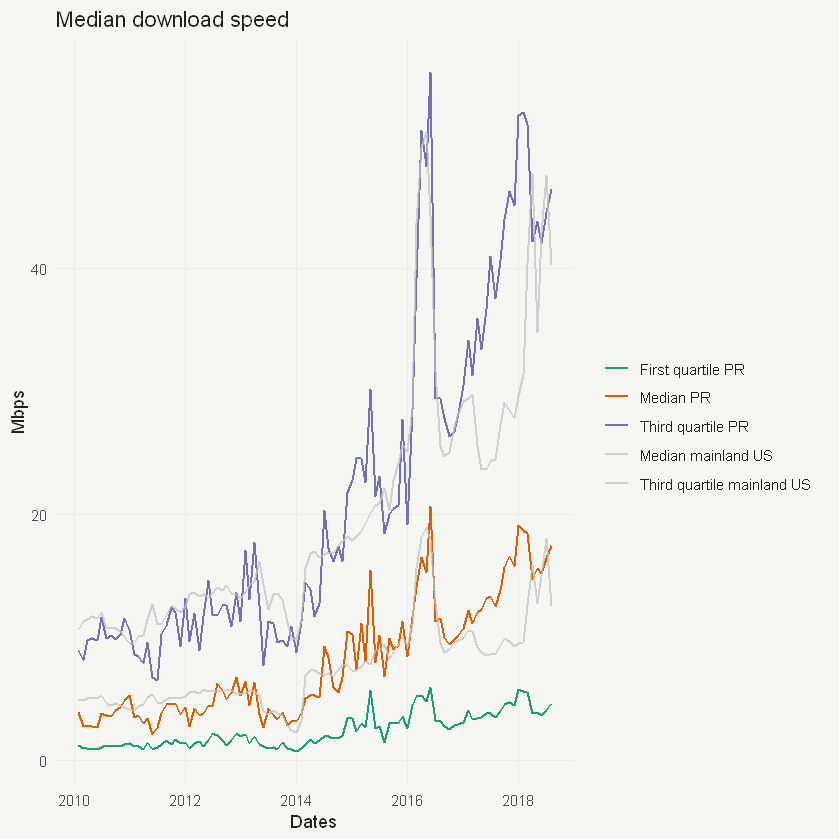

In [12]:
med.D<-todo_copies%>%group_by(ip, day)%>%summarise("num"=median(d_mps))
iqr_plot(D=med.D,
         D.to.join=todo_copies_USA,
         cutoff_date = ymd("2010-01-01"), 
         titles = "Median download speed",
         labs =  c("First quartile PR", "Median PR", "Third quartile PR","Median mainland US", 
                   "Third quartile mainland US"))


### Clutering for geographical analysis

Now we're turning to the geographical analysis of NDT speeds over time. Because the density of users and tests is unequal spatially, it can be difficult to see geographical trends. However, by grouping nearby zipcodes (ZCTA) togther using clustering methods, it becomes easier to see the trends that are already there. 

The first step in this kind of unsupervised clustering is deciding how many clusters to settle on. A common way of approaching this is the "elbow method." First, you calculate what the clusters would look like for many different cluster numbers and after getting the clusters, you calculate how similar the elements in one cluster are to one another for each cluster set. 

You then plot that statistic, the "total within-cluster sum of squares," against the number of clusters that produced that WSS. Using the "elbow rule" means to choose the number of clusters at the "elbow" of the plot, the place where the initial sharp downard slope starts to flatten out. 

The intuitive justification is that the elbow represents the value where increasing the number of clusters starts to garner diminishing returns . You're increasing the number of clusters (which is akin to overfitting, or further fitting _this_ data as opposed to the population data) without getting back all that much more in-cluster similarity.



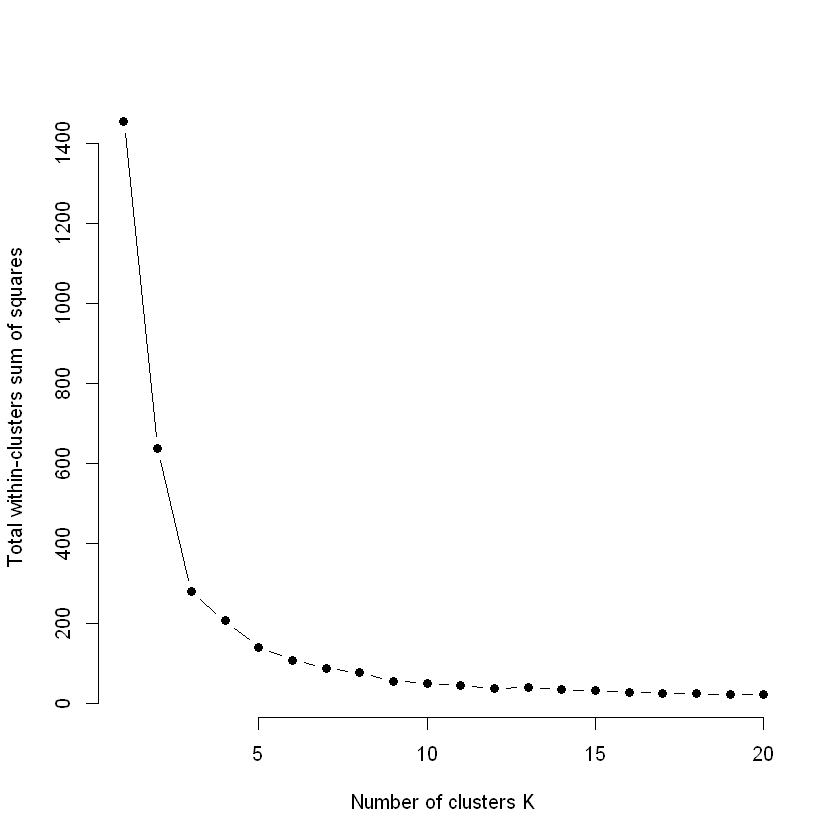

In [223]:
df<-data.frame(lon=D.spatial.d$lon, lat=D.spatial.d$lat)%>%na.omit%>%mutate_all(as.character)
df<-todo_copies[,c(4,3)]%>%na.omit%>%mutate_all(as.character)
lon.win <-c(-78.22464,-75.9518)
lat.win <-c(37.87082, 39.51871)
df1<-df%>%na.omit%>%mutate_all(as.numeric)%>%filter(lon.win[2]>lon)%>%filter(lon>lon.win[1])%>%
###checking number of clusters
set.seed(123)
# Compute and plot wss for k = 2 to k = 15.
k.max <- 20
data <- df1
wss <- sapply(1:k.max, 
              function(k){kmeans(data, k,nstart=50,iter.max = 1000)$tot.withinss})
plot(1:k.max, wss,
     type="b", pch = 19, frame = FALSE, 
     xlab="Number of clusters K",
     ylab="Total within-clusters sum of squares")

In [252]:
df<-todo_copies[,c(4,3)]%>%na.omit
lon.win <-c(-77.12,-76.9)
lat.win <-c(38.8, 38.999)
df1<-df%>%na.omit%>%filter(lon.win[2]>lon)%>%filter(lon>lon.win[1])%>%
  filter((lat.win[2]>lat))%>%filter(lat>lat.win[1])%>%distinct

Here that number appears to be between four and eight. We choose seven, and use this number to produce a segmentation of Washington D.C. into "tiles." Below are the k-means tiles and the ZCTA of Washington D.C. prior to combining the two.

Getting data from the 2012-2016 5-year ACS
although coordinates are longitude/latitude, st_intersection assumes that they are planar


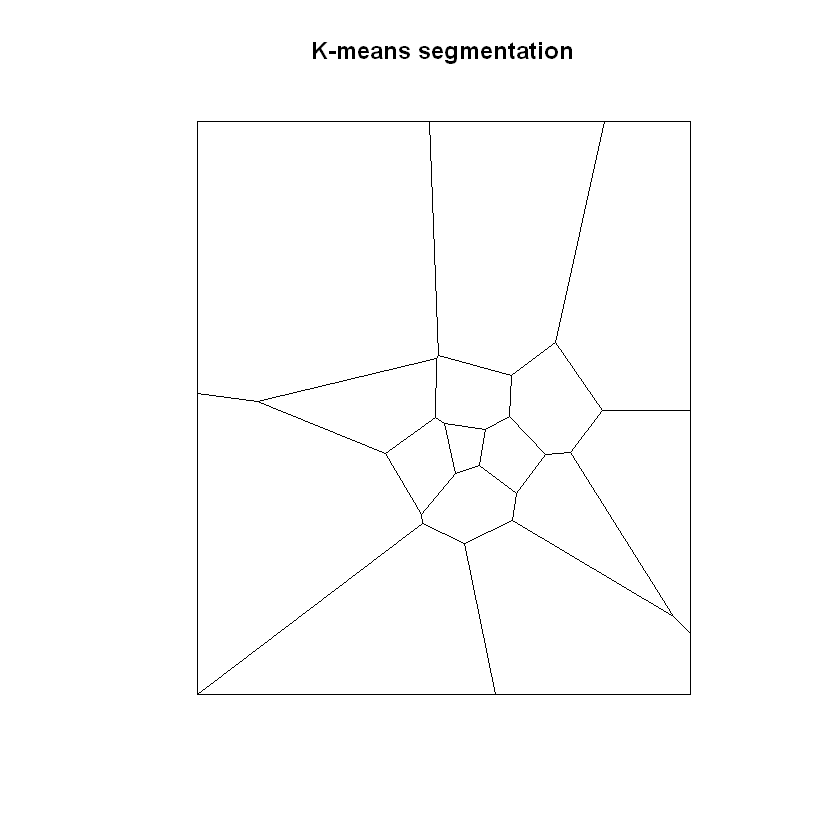

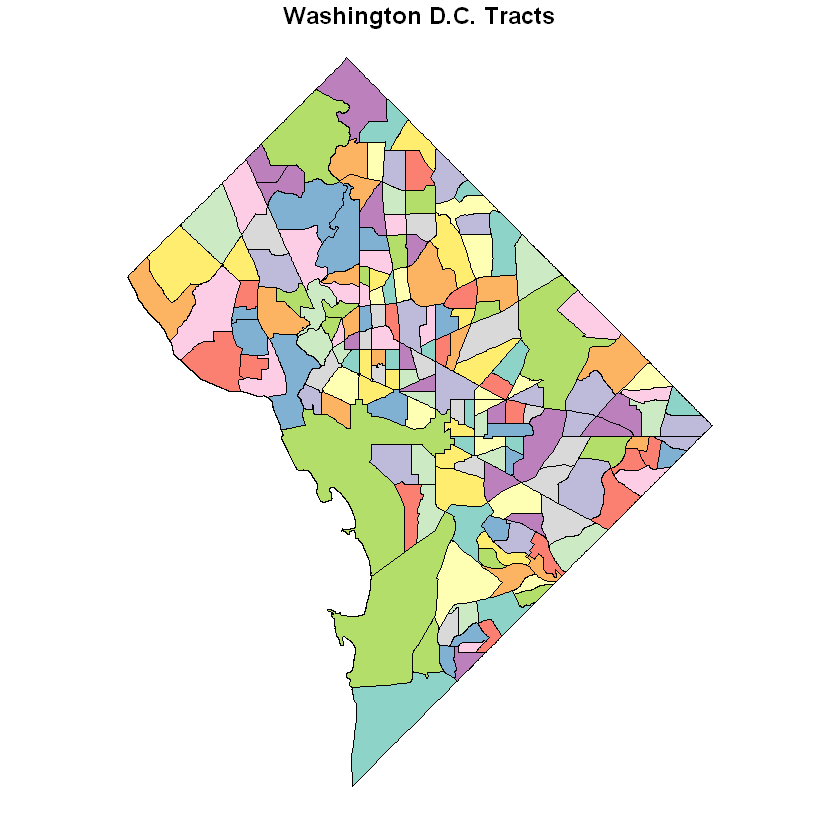

In [258]:
df2<-kmeans(df1, 15, nstart = 100, iter.max = 1000)
W <- ripras(df2$centers, shape="rectangle")
W <- owin(c(-77.2, -76.9), c(38.75082, 39.1))
X <- as.ppp(df2$centers, W=W) 
voronoi<-dirichlet(X)
vor.tiles<- as(voronoi, "SpatialPolygons") 
vor.tiles.df<-SpatialPolygonsDataFrame(vor.tiles,data.frame(vor=1:length(vor.tiles)),match.ID=F)
pr_acs<-get_acs(geography = "tract",variables = "B19013_001",geometry=TRUE, cb=FALSE, state="DC") 
locs<-pr_acs$geometry
vor.sf<-as(vor.tiles.df, "sf")
vor.sf$vor<-as.factor(vor.sf$vor)
zcta.sf<-locs%>%st_sfc%>%st_sf
name<-1:nrow(zcta.sf)
zcta.sf$zcta = name
zcta.sf$zcta<-as.factor(zcta.sf$zcta)
st_crs(vor.sf)<-st_crs(zcta.sf)
st_int<-st_intersection(vor.sf, zcta.sf)
attArea <- st_int %>%mutate(area = st_area(.) %>% as.numeric())
join_D<-attArea%>%as_tibble()%>%group_by(vor, zcta)%>%summarize(area = sum(area))%>%group_by(zcta)%>%
  summarise("shared_vor"=vor[which.max(area)])%>%group_by(shared_vor)
plot(vor.tiles, main="K-means segmentation")
plot(zcta.sf, main="Washington D.C. Tracts")

### Geographical analysis

With both shapefiles, we can cluster the ZCTAs into groups according to their overlaps with the k-means tiles by taking the intersections of the two and assigning a ZCTA to a tile if over 50% of the area of that ZCTA is inside the tile. Below is the clustering of ZCTAs into larger regions for the purpose of geographical analysis.

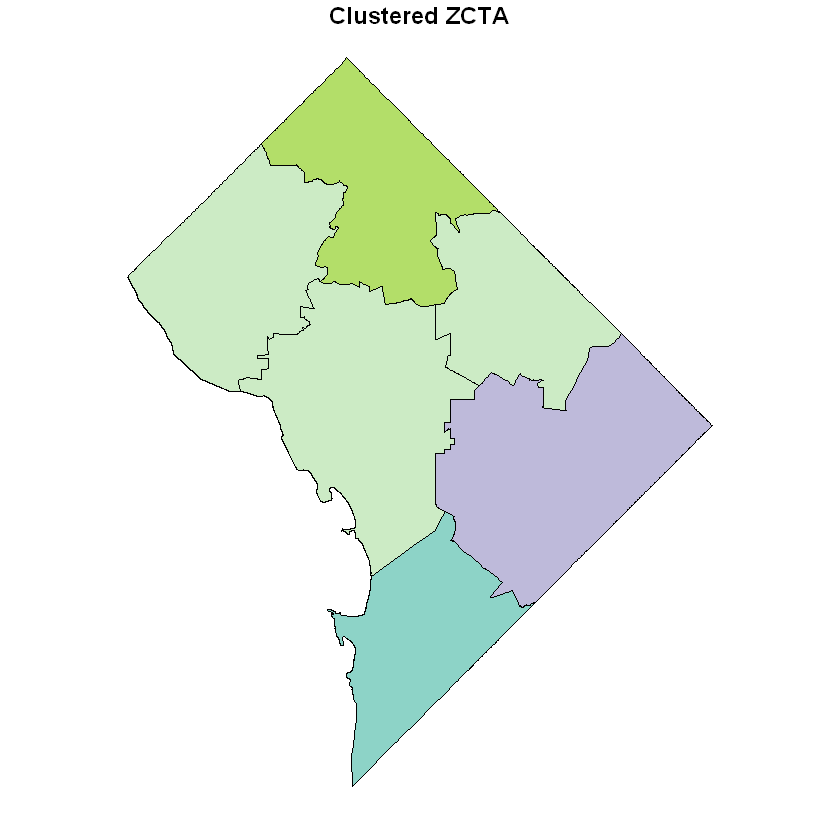

In [254]:
###this joins the zctas that are assigned to the same voronois
skip.list<-c()
for(i in 1:nrow(join_D)){
  vor.num<-join_D[i,]$shared_vor
  vor.inds<-which(join_D$shared_vor==vor.num)
  if(length(vor.inds)==1){
    next
  }else{
    if(i%in%skip.list){
      next
    }
    zcta.sf.ind<-which(zcta.sf$zcta%in%join_D[vor.inds,]$zcta)
    new.feat<-zcta.sf[zcta.sf.ind,]%>%st_union
    zcta.sf$geometry[zcta.sf.ind[1]]<-new.feat
    zcta.sf<-zcta.sf[(1:length(zcta.sf$geometry))[-zcta.sf.ind[-1]],]
    skip.list<-c(skip.list, vor.inds)
  }
}
plot(zcta.sf, main="Clustered ZCTA")

### Geographical analysis
One thing that's particularly nice about tidy census and the spatial features, or "sf" objects, in R is that they allow for the easy aggregation of demographic and non-spatial data while performing spatial joins. The spatial clustering and joins above could cause real headache in trying to keep track of what data went with which ZCTA, but tidy census lets us augment our data with a flag we can use to re-join the newly clustered ZCTA regions with the old ZCTA data. That means assigning the Mbps data to the right place is a one-liner. 

The join isn't particularly fast with more than a million entries, but we only need to perform it once and we can produce the plots we like after. 

Here we produce four plots of the NDT test speeds per region over four time periods: 2009-2011, 2011-2013, 2013-2015, and from 2015-2018

although coordinates are longitude/latitude, st_intersects assumes that they are planar
Joining, by = "zcta"
Joining, by = "zcta"
Joining, by = "zcta"
Joining, by = "zcta"


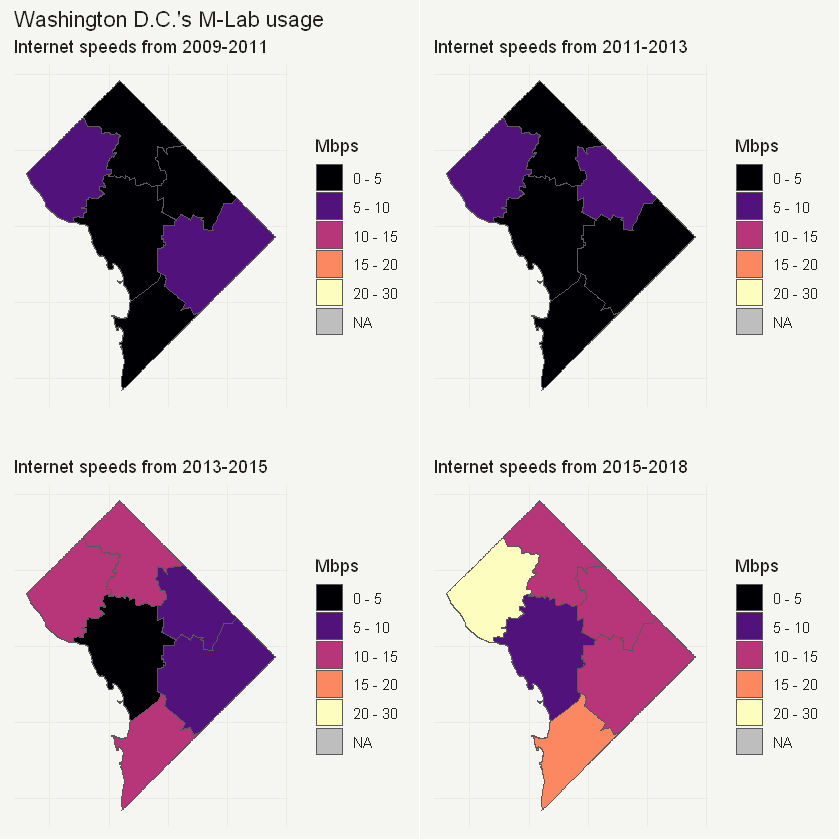

In [255]:
st_crs(D.spatial)<-st_crs(zcta.sf)
D.joined<-st_join(D.spatial, zcta.sf)
D.joined.sum<-D.joined%>%data.frame%>%group_by(zcta,ip, day)%>%summarise("med"=median(d_mps))

num_title<-"Washington D.C.'s M-Lab usage"
num_subtitle<-'Internet speeds from 2009-2011'
D.plot1<-D.joined.sum%>%data.frame%>%filter(ymd(day)%within%interval(ymd("2009-09-01"),ymd("2011-01-01")))%>%group_by(zcta)%>%
  summarise("n"=n(),"med"=median(med))%>%filter(n>2)%>%left_join(x=zcta.sf)%>%map_prep(quant=c(0,5, 10,15,20,30), NA_val="NA", no_classes=6)
D.plot2<-D.joined.sum%>%data.frame%>%filter(ymd(day)%within%interval(ymd("2011-01-01"),ymd("2013-12-01")))%>%group_by(zcta)%>%
  summarise("n"=n(),"med"=median(med))%>%filter(n>2)%>%left_join(x=zcta.sf)%>%map_prep(quant=c(0,5, 10,15,20,30), NA_val="NA", no_classes=6)
D.plot3<-D.joined.sum%>%data.frame%>%filter(ymd(day)%within%interval(ymd("2013-01-01"),ymd("2015-07-01")))%>%group_by(zcta)%>%
  summarise("n"=n(),"med"=median(med))%>%filter(n>2)%>%left_join(x=zcta.sf)%>%map_prep(quant=c(0,5, 10,15,20,30), NA_val="NA", no_classes=6)
D.plot4<-D.joined.sum%>%data.frame%>%filter(ymd(day)%within%interval(ymd("2015-08-01"),ymd("2018-02-01")))%>%group_by(zcta)%>%
  summarise("n"=n(),"med"=median(med))%>%filter(n>2)%>%left_join(x=zcta.sf)%>%map_prep(quant=c(0,5, 10,15,20,30), NA_val="NA", no_classes=6)

colors<-unique(c(D.plot1$colors, D.plot2$colors, D.plot3$colors, D.plot4$colors))
colors<-c(viridis::magma(length(colors)-1), "grey")

pre.plot<-D.plot1$data%>%ggplot(aes(fill=med), color=med)+geom_sf()+scale_fill_manual(values=colors,drop=FALSE,name="Mbps")+
labs(title=num_title, subtitle=num_subtitle)+theme(legend.position="none")+theme_map()

num_title<-""
num_subtitle<-'Internet speeds from 2011-2013'

plot.2016<-D.plot2$data%>%ggplot(aes(fill=med), color=med)+geom_sf()+scale_fill_manual(values=colors,drop=FALSE,name="Mbps")+
  labs(title=num_title, subtitle=num_subtitle)+theme(legend.position="none")+theme_map()

num_title<-""
num_subtitle<-'Internet speeds from 2013-2015'

pre.hurr<-D.plot3$data%>%ggplot(aes(fill=med), color=med)+geom_sf()+scale_fill_manual(values=colors,drop=FALSE,name="Mbps")+
  labs(title=num_title, subtitle=num_subtitle)+theme(legend.position="none")+theme_map()

num_title<-""
num_subtitle<-'Internet speeds from 2015-2018'

post.hurr<-D.plot4$data%>%ggplot(aes(fill=med), color=med)+geom_sf()+scale_fill_manual(values=colors,drop=FALSE,name="Mbps")+
  labs(title=num_title, subtitle=num_subtitle)+theme(legend.position="none")+theme_map()

grid.arrange(pre.plot, plot.2016,pre.hurr,post.hurr)

The results are in keeping with the plot from above, but these allow us to see regional differences in internet speed, and the way those speeds change over time.  Speeds are below 10 Mbps for all regions prior to 2013. From 2013 on, we start to see DC-wide improvements, as every region in D.C moves up at least one speed category from the beginning of 2013 to 2018. There are two takeaways from this graph, The first is that one region, the region all the way to the left, has the fastest internet from the beginning of the time period to the end. That's not suprising, as that is the area containing Georgetown, an extremely wealthy part of the city.. The second is the huge improvement of the bottom-most region. That's extremely surprising, because if true, it would mean rapidly increasing internet speeds for one of the least-affluent neighborhoods in the city. However, this increase is driven by one census tract within Southeast, so it's hard to confirm whether the change is real.
